# Initial Function Dump

In [54]:
from ringdb import Database
import ringdown
import numpy as np
import pandas as pd
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt


# Set up database
data_folder = "./Data" # Folder where the downloaded strain data is saved
alternative_data_folder = "./AlternativeData" # Folder where the strain is saved

db = Database(data_folder)
db.initialize()

db.update_posterior_schema({'f_low': {'path': "/{approximant}/meta_data/meta_data/f_low", 'type':'value'}})
db.update_posterior_schema({'f_ref': {'path': "/{approximant}/meta_data/meta_data/f_ref", 'type':'value'}})

import os
import urllib

### Class to download and manage strain files that interfaces with the
### strain file API from the ringdown package
class StrainFileManager:
    def __init__(self, Folder : str, StrainDB):
        self.Folder = Folder
        self.StrainDB = StrainDB
        self.all_events = self.StrainDB.url_df.Event.unique()
        
    def get_url(self,eventname, detector, duration=32.0):
        return self.StrainDB.get_url(eventname, detector, duration=duration)
    
    def filename(self,url):
        return f"{self.Folder}/{url.split('/')[-1]}"
    
    def download_file(self, eventname, detector, duration=32.0, force=False):
        url = self.get_url(eventname, detector, duration)
        file = self.filename(url)
        download_it = False
        if os.path.exists(file):
            download_it = force
        else:
            download_it = True
            
        if download_it:
            print(f"Downloading from {url}")
            filename = self.filename(url)
            print(f"Into folder {filename}")
            urllib.request.urlretrieve(url, filename)
            
        return file
    
    def load_data_dict(self, eventname, ifos=["H1","L1"], duration=32.0):
        data_dict = {}
        for ifo in ifos:
            filepath = self.download_file(eventname, ifo, duration)
            #places = filepath.split("_GWOSC_16KHZ_")
            #postfix = places[-1]
            #prefix = "/".join(places[0].split("/")[0:-1])
            #data_dict[ifo] = prefix + "/{i}-{ifo}_GWOSC_16KHZ_" + postfix
            data_dict[ifo] = filepath
        return data_dict
     
SFM = StrainFileManager(alternative_data_folder, db.StrainDB)
    
# Define functions
def get_target(eventname, N_samps=None, target_sample_rate=4096, f_low=20, f_ref=20, q=0.5):
    """
    Calculates the sky location and start time that will be chosen for the fit object. 
    This function will 
    1. randomly get a subset posterior samples (of size `N_samps`)
    2. calculate the geocenter peak strain for each of the posterior samples
    3. choose the `q`-th quantile (i.e. `q*100`-th percentile) sample and package its t0, ra, dec and psi 
    
    
    Parameters
    -----------
    eventname : str
        The name of the event e.g. "GW150914"
    N_samps : int
        This many samples will be chosen from the posterior for the actual analysis. Some IMR posteriors have too many samples.
        Defaults to using all samples
    target_sample_rate : float
        The waveform generator will use this sample rate when generating waveforms
    f_low : float (default : 20)
        f_low
    f_ref : float (default : 20)
        reference frequency
    q :  float (default : 0.5)
        The chosen sample for the target will be the one which lands on the `q`-th quantile when ordered by the geocent peak time. 
        
        
    Returns
    --------
    args : Dict with keys 't0', 'ra', 'dec' and 'psi' 
        This is a dictionary of the chosen target parameters.
    median_samp : pd.Series
        This is the chosen median sample. Returned if any other parameters like final_mass and final_spin are needed. 
    samps : pd.DataFrame
        A dataframe of all the samples that were chosen for calculation and their corresponding peak times at each ifo.
    
    """
    event = db.event(eventname)
    strains = event.strain()
    posts = event.posteriors()

    N_samps = N_samps or len(posts)

    try:
        f_low = float(event.read_posterior_file_from_schema('f_low'))
        f_ref = float(event.read_posterior_file_from_schema('f_ref'))
        print(f"f_low is set to {f_low}")
        print(f"f_ref is set to {f_ref}")
        waveform_name = posts['waveform_name'].unique()[0]
        waveform_code = int(posts['waveform_code'].unique()[0])
    except:
        print("Falling back to f_ref = 20, f_low=20")
        waveform_name = posts['waveform_name'].unique()[0]
        waveform_code = int(posts['waveform_code'].unique()[0])
        f_low = f_low
        f_ref = f_ref


    print(f"Using {waveform_name}")
    wf_ls = waveform_code
    sample_rate = np.max([a.fsamp for a in strains.values()])


    samps = [x.to_dict() for i,x in posts.sample(N_samps).iterrows()]

    for i,x in enumerate(samps):
        t_peak, t_dict, hp, hc = ringdown.complex_strain_peak_time_td(x,
                                                                      wf=wf_ls, dt=1/target_sample_rate,
                                                                      f_ref=f_ref, f_low=f_low)
        samps[i].update({k+'_peak':v for k,v in t_dict.items()})

    samps = pd.DataFrame(samps)

    # Get median sample
    ref_ifo = 'H1'
    im = (samps[f'{ref_ifo}_peak'] - samps[f'{ref_ifo}_peak'].quantile(q)).abs().argmin()
    median_samp = samps.iloc[im]

    # Construct Arguments for set_target
    args = median_samp[['geocent_peak', 'ra','dec','psi']].rename({'geocent_peak':'t0'}).to_dict()
    print("The median time at H1 is: ", median_samp['H1_peak'], "s")

    # Get the mass time-scale
    Mass_Time = lambda M: 6.674e-11*M*1.989e+30/(3e8)**3
    t_M = Mass_Time(median_samp['final_mass'])
    print("The mass time-scale is: ", np.round(t_M*1000,3), "ms")

    times_above_below = (samps['H1_peak'].quantile(0.95) - samps['H1_peak'].quantile(0.05))/(2*t_M)
    print(f"The 90% CI of H1 peak time is +/- {np.round(times_above_below,1)} t_M")

    return args, median_samp, samps

def set_fit(eventname, target, mass_for_prior, duration=0.1, target_sample_rate=4096, model='mchiq_exact', modes=[(1, -2, 2, 2, 0), (1, -2, 2, 2, 1)], cond_kws = None, **model_kwargs):

    '''
    The convention for modes is (prograde, s, l, m, n)
    The options for models are mchi, mchiq, and mchiq_exact. 
    mchiq is for all beyond-GR EVP applications.
    You can change the beyon-GR model using the kwargs, which get passed to ringdown.Fit
    The coefficients must be created by fitting EVP data as a separate step.
    df_coeffs = [[a0,a1,a2,a3...],[a0,a1,a2,a3...],..]; n_modes x n_coeffs for the frequency shifts
    dg_coeffs = (similar structure as df) for the decay rate shifts
    '''
    
    event = db.event(eventname)
    strains = event.strain()
    load_data_dict = SFM.load_data_dict(eventname, ifos=list(strains.keys()))
    
    #Hacking in ability to change amplitude priors:
    #Aprior = model_kwargs.pop('flat_A',1)
    
    fit = ringdown.Fit(model=model, modes=modes, **model_kwargs)
    
    fit.load_data(load_data_dict, kind="gwosc")
    
    #for ifo in strains.keys():
    #    fit.add_data(strains[ifo])
        
    sample_rate = np.max([f.fsamp for f in strains.values()])

    fit.set_target(**target, duration=duration)
    
    #Adding a cond kwargs to allow us to low pass or add other conditioning arguments
    default_kws = dict(digital_filter=True)
    default_kws.update(cond_kws or {})
    
    #Revisit the trim = 0 setting. Why was this done? Naively this should be set to a nonzero value

    fit.condition_data(ds=int(sample_rate/target_sample_rate),**default_kws)
    fit.compute_acfs()

    #fit.update_prior(A_scale=5e-21, M_min=mass_for_prior*0.5,
    #                 M_max=mass_for_prior*2.0,
    #                 flat_A=1)
    fit.update_prior(A_scale=5e-21, M_min=mass_for_prior*0.5,
                     M_max=mass_for_prior*2.0,
                     flat_A=1)
    return fit

In [7]:
eventname = "GW150914" # Name of the event

args, median_samp, samps = get_target(eventname=eventname,  # name of the event
                                      N_samps=800, # size posterior samples subset used for this computation  
                                      q=0.5)        # the sample with the q*100 % percentile sample is picked out) 

f_low is set to 20.0
f_ref is set to 20.0
Using IMRPhenomXPHM
The median time at H1 is:  1126259462.4241433 s
The mass time-scale is:  0.308 ms
The 90% CI of H1 peak time is +/- 5.1 t_M


In [13]:
model = 'mchiq_exact'   # Choose one of `mchi`, `mchiq` (needs extra parameters below), `mchiq_exact`

fit = set_fit(eventname = eventname,                          # Name of the event e.g. "GW150914"
              target = args,                                  # Dictionary of target arguments t0, ra, dec & psi
              mass_for_prior = median_samp['final_mass'],     # Provide a mass M -  the mass prior will be [0.5M, 1.5M]
              duration = 0.03,                                 # Duration of the strain segment for analysis
              target_sample_rate = 4_096,                     # The sample rate of the segment you would like for final analysis
              model = model,                                   # Choose one of `mchi`, `mchiq` (needs extra parameters below), `mchiq_exact`
              modes = [(1, -2, 2, 2, 0), (1, -2, 2, 2, 1)],    # Modes (p,s,l,m,n)
              cond_kws={'flow':20.0}                            # Add any keywords to the data.condition() function. In this case we low pass at 20 Hz
             # Additional Args (only viable for mchiq which works for general first orderr shifts): 
             # df_coeffs = [[a0,a1,a2,a3...],[a0,a1,a2,a3...],..]; n_modes x n_coeffs for the frequency shifts
             # dg_coeffs = similar to above
             )

In [14]:
fit.run()

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, r2_qchi, theta_qchi, Apx_unit, Apy_unit, Acx_unit, Acy_unit]
INFO:pymc:NUTS: [M, r2_qchi, theta_qchi, Apx_unit, Apy_unit, Acx_unit, Acy_unit]
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 112 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 112 seconds.


array([[<AxesSubplot: title={'center': 'M'}>,
        <AxesSubplot: title={'center': 'M'}>],
       [<AxesSubplot: title={'center': 'chi'}>,
        <AxesSubplot: title={'center': 'chi'}>]], dtype=object)

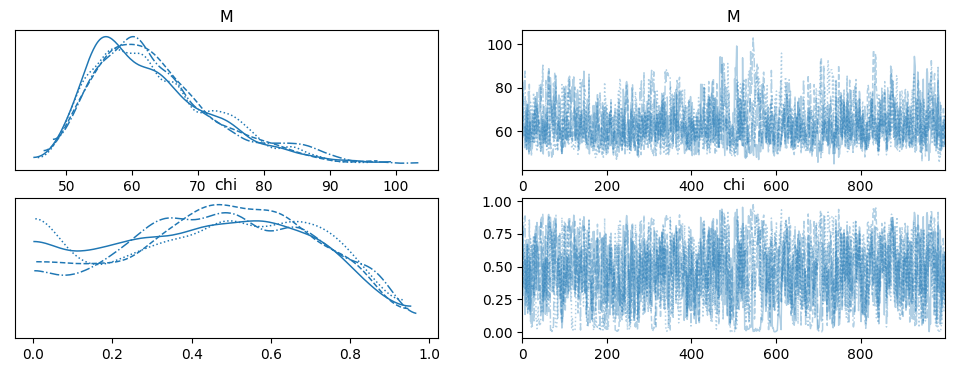

In [12]:
az.plot_trace(fit.result, var_names=['M','chi'])

array([[<AxesSubplot: title={'center': 'M'}>,
        <AxesSubplot: title={'center': 'M'}>],
       [<AxesSubplot: title={'center': 'chi'}>,
        <AxesSubplot: title={'center': 'chi'}>],
       [<AxesSubplot: title={'center': 'Q_charge'}>,
        <AxesSubplot: title={'center': 'Q_charge'}>]], dtype=object)

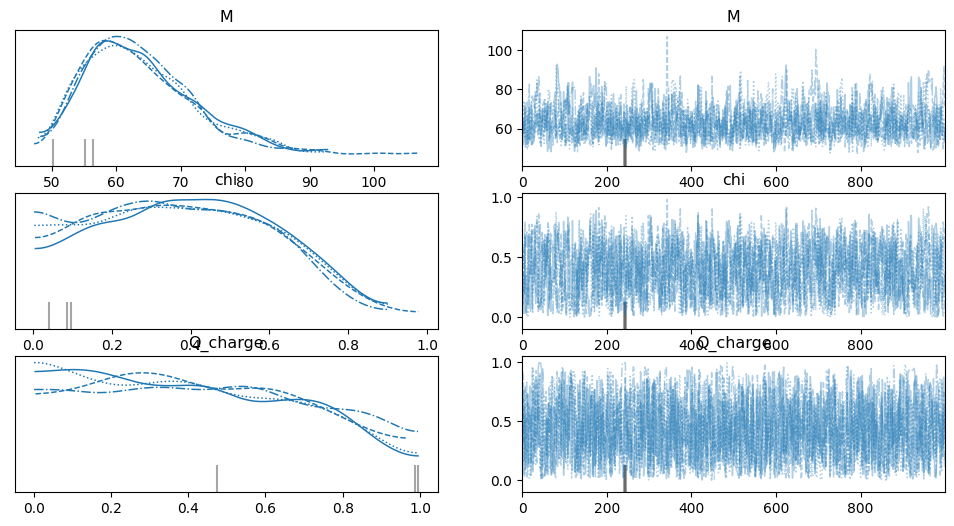

In [16]:
az.plot_trace(fit.result, var_names=['M','chi','Q_charge'])

## Example Task

Lets say my task is to do multiple runs with different start times. 

For every run we need one or multiple "key" type fields, which would completely specify a particular run. 



So we might want 5 runs at the $10\%, 30\%, 50\%, 70\%$ and $90\%$ percentile of the start-time at H1. The ra and dec would also change. 

In [100]:
model = "mchi"
#eventname = "GW150914"

quantiles = [10,30,50,70,90]

keys = quantiles

tasks = [{} for _ in range(len(keys))]

set_fit_dict_keys = ["eventname", "target", "mass_for_prior", "duration", 
                     "target_sample_rate", "model", "modes", "cond_kws"]

for i,task in enumerate(tasks):
    ## Name of run
    task["name"] = f"{model}-{eventname}-{i}-{keys[i]}-percentile"
    
    ## Eventname
    task["eventname"] = eventname
    
    ## Model and modes
    task["model"] = model
    task["modes"] = [(1, -2, 2, 2, 0), (1, -2, 2, 2, 1)]   # Modes (p,s,l,m,n)
    
    ## Create targets from these quantiles 
    ref_ifo = 'H1'
    im = (samps[f'{ref_ifo}_peak'] - samps[f'{ref_ifo}_peak'].quantile(i/100)).abs().argmin()
    task["target"] = samps.iloc[im][["geocent_time", "ra","dec","psi"]].rename({"geocent_time": "t0"},axis=0).to_dict()
    
    ## Mass for prior
    task["mass_for_prior"] = samps["final_mass"].median()
    
    ## Duration
    task["duration"] = 0.03
    
    ## Sample Rate
    task["target_sample_rate"] = 4_096
    
    ## Conditioning 
    task["cond_kws"] = {'flow':20.0}
    
    ## Create the fit object
    task["fit"] = set_fit(**{k:v for k,v in task.items() if k in set_fit_dict_keys})
    


From these we need to create 
- reference to the folder name for each run.
- reference to the config file for each run. 
- reference to the output file for each run. 
- a general gwosc-data folder reference 

We can then create the above given the info we have. 

In [122]:
import os

script_masterfolder = "./PercentileSweep"
masterfolder = "."

binary_file = f"{masterfolder}/ringdown_fit"
if not os.path.exists(binary_file):
    binary_file_url = "https://raw.githubusercontent.com/Potatoasad/ringdown/main/bin/ringdown_fit"
    urllib.request.urlretrieve(binary_file_url, binary_file)


for task in tasks:
    run_folder = f"{masterfolder}/{task['name']}"
    script_run_folder = f"{script_masterfolder}/{task['name']}"
    task["folder"] = run_folder
    os.makedirs(script_run_folder, exist_ok = True)
    
    run_config = f"{masterfolder}/{task['name']}/{task['name']}.cfg"
    script_run_config = f"{script_masterfolder}/{task['name']}/{task['name']}.cfg"
    task["config"] = run_config
    task["fit"].to_config(script_run_config)
    
    task["output_file"] = run_config.replace(".cfg", "-output.nc")
    
    task["run_command"] = f"""{masterfolder}/ringdown_fit {run_config} -o {task["output_file"]}"""

    
os.remove(f'{script_masterfolder}/taskfile')

for task in tasks:
    with open(f'{script_masterfolder}/taskfile', 'a') as taskfile:
        taskfile.write(task["run_command"] + "\n")

In [115]:
import json

In [117]:
with open(f'{script_masterfolder}/tasks_json','w') as tasks_json:
    json.dump([{k:v for k,v in task.items() if k not in ["fit"]} for task in tasks],
             tasks_json)

In [120]:
with open(f'{script_masterfolder}/tasks_json','r') as f:
    imported_task_file = json.load(f)


In [121]:
imported_task_file

[{'name': 'mchi-GW150914-0-10-percentile',
  'eventname': 'GW150914',
  'model': 'mchi',
  'modes': [[1, -2, 2, 2, 0], [1, -2, 2, 2, 1]],
  'target': {'t0': 1126259462.4081554,
   'ra': 2.154322051373299,
   'dec': -1.2346851700266028,
   'psi': 1.3399656139244793},
  'mass_for_prior': 67.15875375547412,
  'duration': 0.03,
  'target_sample_rate': 4096,
  'cond_kws': {'flow': 20.0},
  'folder': './mchi-GW150914-0-10-percentile',
  'config': './mchi-GW150914-0-10-percentile/mchi-GW150914-0-10-percentile.cfg',
  'output_file': './mchi-GW150914-0-10-percentile/mchi-GW150914-0-10-percentile-output.nc',
  'run_command': './PercentileSweep/ringdown_fit ./mchi-GW150914-0-10-percentile/mchi-GW150914-0-10-percentile.cfg -o ./mchi-GW150914-0-10-percentile/mchi-GW150914-0-10-percentile-output.nc'},
 {'name': 'mchi-GW150914-1-30-percentile',
  'eventname': 'GW150914',
  'model': 'mchi',
  'modes': [[1, -2, 2, 2, 0], [1, -2, 2, 2, 1]],
  'target': {'t0': 1126259462.4080045,
   'ra': 2.1443739610360